# Cross validation and model selection

In [31]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston, load_digits
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

## Threefold split and parameter search
The simplest way to adjust parameters is to split the data into three parts: a training, a validation and a test set.
For each parameter setting, we fit a model on the training set, and evaluate it on the evaluation set.
We select the "best" parameter setting (or model) based on the validation set. We then rebuild a model using training and
validation data with this parameter setting, and evaluate it on the test set. The test set performance serves as an estimate of the generalization performance.

### Task 1
Load the boston housing data. Split the data into three parts, for example by calling ``train_test_split`` twice.
As yesterday, scale the data and create polynomial features.
Search the best setting for the regularization parameter alpha using the strategy described above.


In [3]:
boston = load_boston()

In [4]:
alphas = np.logspace(-3, 3, 7)
np.set_printoptions(suppress=True)
print(alphas)

[    0.001     0.01      0.1       1.       10.      100.     1000.   ]


In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(boston.data, boston.target, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_trainval = scaler.transform(X_trainval)
X_test = scaler.transform(X_test)

print("Performing parameter search...")
scores = []
print("{0:>12s} {1:>12s}".format("alpha","score"))
for a in alphas:
    ridge = Ridge(a)
    ridge.fit(X_train, y_train)
    score = ridge.score(X_val, y_val)
    scores.append(score)
    print("{0:12.6f} {1:12.6f}".format(a,score))
    
print("maximum score = {:12.6f}".format(scores[np.argmax(scores)]))
myalpha = alphas[np.argmax(scores)]
print("chosen alpha  = {:12.6f}".format(myalpha))

print("Performing fit on entire training set...")
ridge = Ridge(myalpha)
ridge.fit(X_trainval, y_trainval)
print("Peforming test...")
score = ridge.score(X_test, y_test)
print("score = {:12.6f}".format(score))

Performing parameter search...
       alpha        score
    0.001000     0.698127
    0.010000     0.698149
    0.100000     0.698359
    1.000000     0.700425
   10.000000     0.717783
  100.000000     0.759543
 1000.000000     0.568988
maximum score =     0.759543
chosen alpha  =   100.000000
Performing fit on entire training set...
Peforming test...
score =     0.583461


## Cross validation
To get a better understanding of cross-validation, we'll implement it from scratch.
Our goal is to estimate the performance of a single model, let's say ``Ridge(alpha=1)`` on the original Boston housing dataset.

### Task 2
Complete the code below to fit a model for each of the folds of 5-fold cross-validation and compute the hold-out $R^2$ using the ``score method``.

In [12]:
# TODO: problem with masking arrays

X = boston.data[:505]  # we make it divisible by n_folds to make the code simpler
y = boston.target[:505]
scores = []
n_folds = 5
n_samples = len(X)
fold_size = n_samples / n_folds
alpha = 1.0

for fold in range(n_folds):
    
    X_hold_out_mask = np.zeros(X.shape, dtype=np.bool)
    y_hold_out_mask = np.zeros(y.shape, dtype=np.bool)
    
    # assign True to the samples that are supposed to be held out in this fold
    b = int((fold)*fold_size)
    e = int((fold+1)*fold_size)
    print("Hold out the following range: {0}-{1}".format(b,e))
    X_hold_out_mask[b:e,:] = True
    y_hold_out_mask[b:e] = True
    X_training_mask = ~X_hold_out_mask  # training data is inverse of hold out data
    y_training_mask = ~y_hold_out_mask

    # assign training and hold-out portions
    X_train = np.ma.masked_array(X, X_hold_out_mask)
    y_train = np.ma.masked_array(y, y_hold_out_mask)
    X_test = np.ma.masked_array(X, X_training_mask)
    y_test = np.ma.masked_array(y, y_training_mask)
    
    # FIXME - masking works here
    print(X_test[105,:])
    print(X_train[105,:])

    # build model - scaling doesn't seem to be using masks!!
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    ridge = Ridge(alpha)
    ridge.fit(X_train, y_train)
    print(ridge.score(X_train, y_train))

    # FIXME - but masking is now gone!
    print(X_test[105,:])
    print(X_train[105,:])

    # compute scores
    score = ridge.score(X_test, y_test)
    print("score = {:12.6f}".format(score))
    scores.append(score)
    
print(scores)

Hold out the following range: 0-101
[-- -- -- -- -- -- -- -- -- -- -- -- --]
[0.13262 0.0 8.56 0.0 0.52 5.851 96.7 2.1069 5.0 384.0 20.9 394.05 16.47]
0.742522041858
[-0.40349384 -0.48832004 -0.37538041 -0.27288841 -0.29910567 -0.6179684
  1.000203   -0.80320985 -0.52493098 -0.14549091  1.13299322  0.41034991
  0.53341842]
[-0.40349384 -0.48832004 -0.37538041 -0.27288841 -0.29910567 -0.6179684
  1.000203   -0.80320985 -0.52493098 -0.14549091  1.13299322  0.41034991
  0.53341842]
score =     0.742522
Hold out the following range: 101-202
[0.13262 0.0 8.56 0.0 0.52 5.851 96.7 2.1069 5.0 384.0 20.9 394.05 16.47]
[-- -- -- -- -- -- -- -- -- -- -- -- --]
0.742522041858
[-0.40349384 -0.48832004 -0.37538041 -0.27288841 -0.29910567 -0.6179684
  1.000203   -0.80320985 -0.52493098 -0.14549091  1.13299322  0.41034991
  0.53341842]
[-0.40349384 -0.48832004 -0.37538041 -0.27288841 -0.29910567 -0.6179684
  1.000203   -0.80320985 -0.52493098 -0.14549091  1.13299322  0.41034991
  0.53341842]
score =  

### Task 3
Compare the result of your implementation with the result of the ``cross_val_score`` method in scikit-learn.

In [10]:
X_train = X
y_train = y
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
ridge = Ridge(1.0)
ridge.fit(X_train, y_train)
scores_sklearn = cross_val_score(ridge,X_train,y_train,cv=5)

# compare scores_sklearn with scores
print(scores_sklearn)

[ 0.6386759   0.72005835  0.58512144  0.09886789 -0.174504  ]


## Parameter selection with cross-validation
### Task 4
Implement the same search over the parameter ``alpha`` in ``Ridge`` that you did in Task 1, but instead of splitting the data three times use cross-validation.
In more detail:
- Split the Boston housing data (with polynomial features) into two parts, training and testing
- Loop over different values of alpha
- for each value of alpha, call ``cross_val_score`` on the training set, and compute the mean cross-validated accuracy.
- Select the parameter with the best mean crossvalidation accuracy, and build a model on all of the training data
- evaluate the model on the test data.

In [25]:
alphas = np.logspace(-3, 3, 7)
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Performing parameter search...")
scores = []
for a in alphas:
    print("alpha: {0}".format(a))
    ridge = Ridge(a)
    ridge.fit(X_train, y_train)
    cvscore = cross_val_score(ridge,X_train,y_train,cv=5)
    print("Cross validated scores:")
    print(cvscore)
    score = np.mean(cvscore)
    scores.append(score)
    print("Mean cv score: {0:12.6f}\n".format(score))
    
print("best mean cross-validation score: {:.3f}".format(scores[np.argmax(scores)]))
myalpha = alphas[np.argmax(scores)]
print("best alpha  = {:.3f}".format(myalpha))

print("Performing fit on entire training set...")
ridge = Ridge(myalpha)
ridge.fit(X_trainval, y_trainval)
print("Peforming test...")
score = ridge.score(X_test, y_test)
print("test-set score: {:3f}".format(score))

Performing parameter search...
alpha: 0.001
Cross validated scores:
[ 0.76238697  0.56939068  0.77952221  0.70772969  0.79034167]
Mean cv score:     0.721874

alpha: 0.01
Cross validated scores:
[ 0.76240138  0.56938802  0.77952438  0.7077228   0.79035472]
Mean cv score:     0.721878

alpha: 0.1
Cross validated scores:
[ 0.76254486  0.56936155  0.77954572  0.70765383  0.79048404]
Mean cv score:     0.721918

alpha: 1.0
Cross validated scores:
[ 0.76392265  0.5691061   0.77972178  0.70696038  0.79166431]
Mean cv score:     0.722275

alpha: 10.0
Cross validated scores:
[ 0.77374246  0.56785091  0.77921536  0.70018795  0.79683623]
Mean cv score:     0.723567

alpha: 100.0
Cross validated scores:
[ 0.78133063  0.59449826  0.74215667  0.65395722  0.76706821]
Mean cv score:     0.707802

alpha: 1000.0
Cross validated scores:
[ 0.57349832  0.53316797  0.48419302  0.42576949  0.52893181]
Mean cv score:     0.509112

best mean cross-validation score: 0.724
best alpha  = 10.000
Performing fit on

# GridSearchCV
Because searching for the parameters of a model is such a common task, scikit-learn provides ``GridSearchCV`` which implements the procedure from Task 4 (with some bells an whistles).
To use ``GridSearchCV`` we simply have to define a parameter grid to search as a dictionary, with the key the name of the parameter, and the values the parameters we like to try. The ``GridSearchCV`` class has the same interface as the classification and regression models, and we can call ``fit`` to perform the grid-search with cross-validation. It even refits the model using the best parameters! We can then use ``predict`` or ``score`` to use the model with the best parameters, retrained on the whole training data.

### Task 5
Do the same search from Task 4 (and Task 1) again, this time using ``GridSearchCV`` (from the ``sklearn.model_selection`` module).

In [19]:
alphas = np.logspace(-3, 3, 7)
param_grid = {'alpha':  alphas}
grid = GridSearchCV(Ridge(), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.718
best parameters: {'alpha': 10.0}
test-set score: 0.627


The ``GridSearchCV`` object stored a lot of useful information from the grid-search in the ``cv_results_`` attribute.
The easiest way to access it is to convert it to a pandas datafram:

In [21]:
results = pd.DataFrame(grid.cv_results_)

In [22]:
results.columns

Index(['mean_fit_time', 'mean_score_time', 'mean_test_score',
       'mean_train_score', 'param_alpha', 'params', 'rank_test_score',
       'split0_test_score', 'split0_train_score', 'split1_test_score',
       'split1_train_score', 'split2_test_score', 'split2_train_score',
       'split3_test_score', 'split3_train_score', 'split4_test_score',
       'split4_train_score', 'split5_test_score', 'split5_train_score',
       'split6_test_score', 'split6_train_score', 'split7_test_score',
       'split7_train_score', 'split8_test_score', 'split8_train_score',
       'split9_test_score', 'split9_train_score', 'std_fit_time',
       'std_score_time', 'std_test_score', 'std_train_score'],
      dtype='object')

In [23]:
results.params

0     {'alpha': 0.001}
1      {'alpha': 0.01}
2       {'alpha': 0.1}
3       {'alpha': 1.0}
4      {'alpha': 10.0}
5     {'alpha': 100.0}
6    {'alpha': 1000.0}
Name: params, dtype: object

We can even plot the cross-validation accuracies and their associated uncertainties:

AttributeError: 'DataFrame' object has no attribute 'param_n_neighbors'

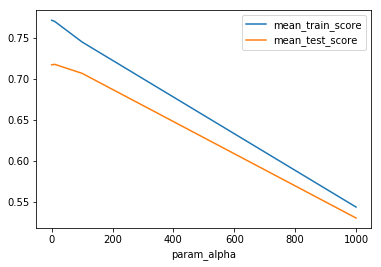

In [32]:
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_.astype(np.int),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_neighbors.astype(np.int),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

### Task 6
Select the best value of ``n_neighbors`` for using ``KNeighborsClassifier`` on the ``digits`` dataset.

## Evaluation Metrics and scoring

In this section, we'll look at different evaluation metrics in scikit-learn and how to use them.
There's two main ways to use metrics:
- As functions in the ``sklearn.metrics`` module, such as ``accuracy_score`` and ``roc_auc``. These take the true labels and the predictions as arguments.
- By specifying a metrics in ``cross_val_score``, ``GridSearchCV`` or another evaluation method using the ``scoring`` keyword, i.e. ``cross_val_score(..., scoring='roc_auc')``.

### Metrics for binary classification
As we mentioned, accuracy is not a great metric in imbalanced classification problems.
We'll look at some alternatives.

### Task 7
Create an imbalanced classification problem from the digits dataset by classifying the digit 4 against all other digits.
Split the data into training and test set.

In [ ]:

# ....
# create X_train, X_test, y_train, y_test for "4 vs rest"

Now train a ``LogisticRegression`` model, a ``DummyClassifier(strategy='most_frequent')`` and a ``DecisionTreeClassifier(max_depth=2)``, and compare their test-set accuracy:

In [ ]:


lr = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=2)
dummy = DummyClassifier(strategy='most_frequent')

# build models
# compare them using accuracy (for example using .score)

To get a better picture, now use the ``classification_report`` function from ``sklearn.metrics``:

The classification report provides precision and recall for the default threshold. To look at all possible thresholds, we can plot the precision-recall curve:

In [ ]:
positive_probs_lr = lr.predict_proba(X_test)[:, 1]
# complete:
# positive_probs_tree = tree.
# plot curves for tree and logistic regression

We can look at a summary by computing the average precision (``average_precision_score``):

In [ ]:
# ...


Finally, to use something like ``average_precision_score`` in cross-validation, we can simply specify the ``scoring`` argument of ``cross_val_score``. Use ``cross_val_score`` to compute the 5 fold cross-validated average precision of ``LogisticRegression`` and ``DecisionTreeClassifier(max_depth=2)``.

In [ ]:
# ... solution here...